<h1 style = "color: green"> Esercitazione 7 </h1>

L'algoritmo di Metropolis può essere applicato per campionare una densità di probabilità in uno spazio con qualsiasi numero di dimensioni. Possiamo quindi sfruttarlo per simulare la stessa situazione dell'esercitazione 4: un sistema di $N=108$ atomi (quindi $3\times N$ dimensionale) di argon, la cui interazione a coppie è modellizzata dal potenziale di Lennard-Jones.  

Studiamo quindi, come abbiamo fatto per la simulazione di dinamica molecolare, l'energia potenziale per particella $U/N$ e la pressione $P$, alle quali abbiamo applicato correzioni per tenere conto della lunga coda del potenzial di LJ che abbiamo ignorato applicando un raggio di cut-off ("tail corrections"). Studiamo anche la funzione di distribuzione radiale $g(r)$.  
Con questo metodo, la temperatura $T$ resta fissa, e quindi anche l'energia cinetica $K$. L'andamento dell'energia totale $E$ è quindi uguale a quello di $U$, traslata di una costante. Queste tre grandezze non sono quindi rilevanti per l'analisi dei risultati.

Usiamo anche in questo caso le unità di misura ridotte ($\sigma = 0.34$ $nm$, $\epsilon/k_B = 120$ $K$, $m=39.948$ $amu$) e studiamo le seguenti situazioni:
- fase solida: $\rho^* = 1.1$, $T^* = 0.8$ (raggio di cut-off: $r_c = 2.2$);
- fase liquida: $\rho^* = 0.8$, $T^* = 1.1$ (raggio di cut-off: $r_c = 2.5$);
- fase gassosa: $\rho^* = 0.05$, $T^* = 1.2$ (raggio di cut-off: $r_c = 5.0$).

Gli esercizi 7.1 e 7.3 riguardano solo la modifica del codice C++ fornito, e sono qui omessi.

<h3 style = "color: blue"> Esercizio 7.2 </h3>

L'algoritmo di Metropolis, per quanto potente, genera configurazioni successive altamente correlate. Vogliamo quindi studiare la funzione di autocorrelazione per i valori di $U/N$ prodotti.  

Per prima cosa dobbiamo termalizzare il sistema nei tre casi. Per fare ciò, simuliamo $N_{term}$ passi e analizziamo l'andamento istantaneo di $U/N$ ($T$ resta fissa). I grafici sono riportati di seguito.

Generiamo quindi, dal sistema termalizzato, $M=5\times 10^5$ valori istantanei di $U/N$ nelle tre condizioni di interesse, che useremo per questa analisi.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

def loadTherm(name):
    dataFile = open(name, "r")
    lines = dataFile.readlines()
    fileLength = len(lines)
    mean = np.empty(fileLength)
    for i in range(fileLength):
        values = lines[i].split()
        mean[i] = float(values[1])

    dataFile.close()

    return mean, fileLength

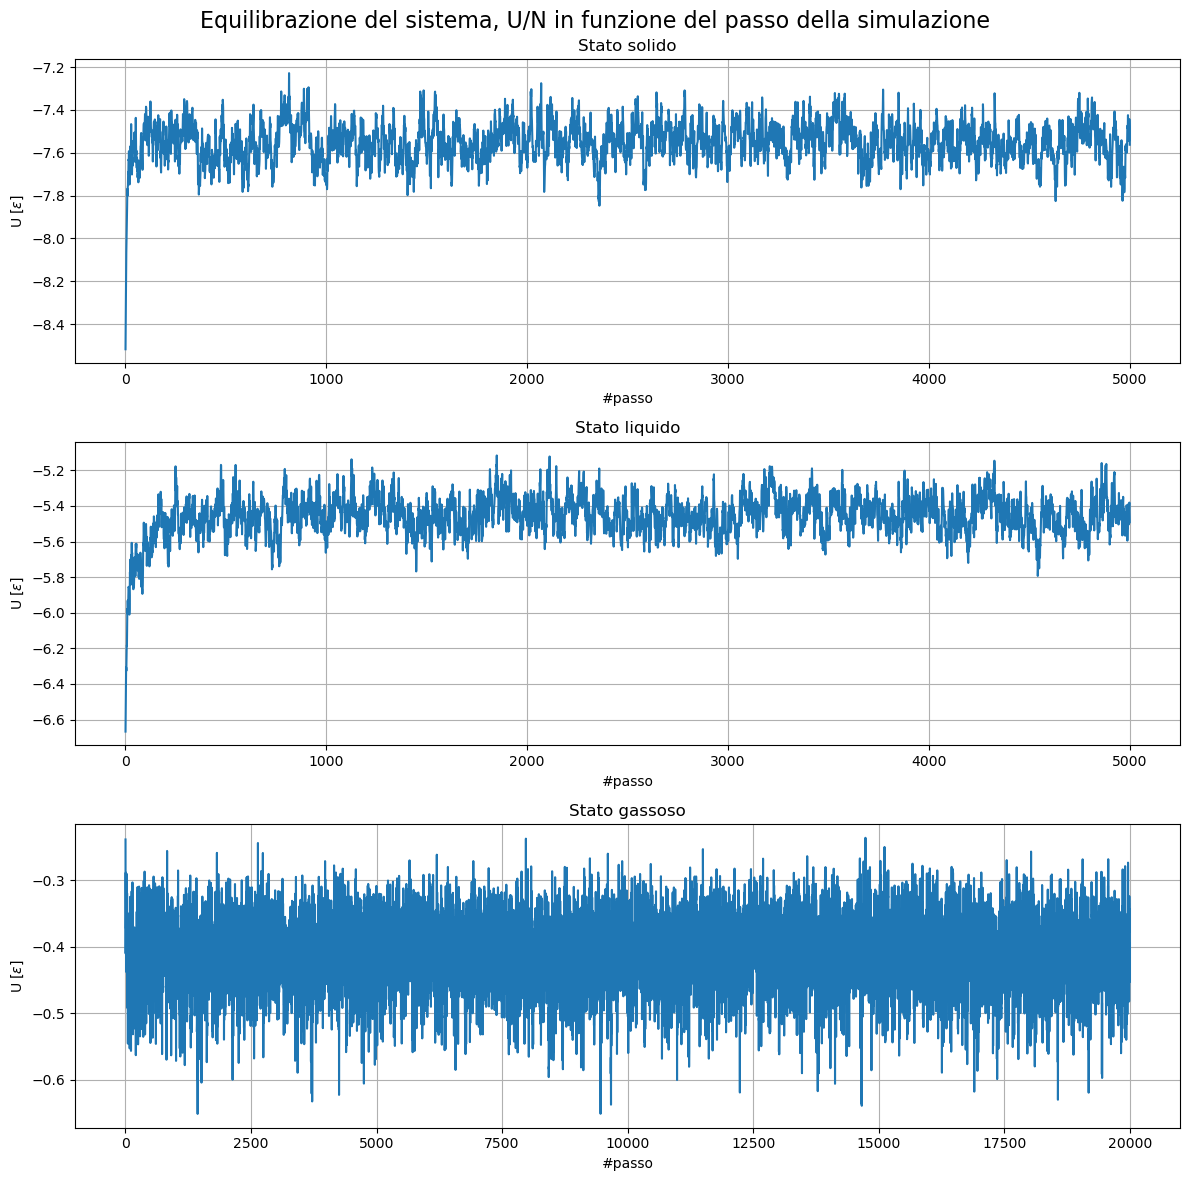

In [2]:
fig, ax = plt.subplots(3, 1, figsize = (12, 12))

mean, fileLength = loadTherm("code/solid/MC/therm_epot.solid")
x = np.arange(fileLength) + 1


ax[0].plot(x, mean)
ax[0].set(title = "Stato solido", xlabel = "#passo", ylabel = "U [$\epsilon$]")
ax[0].grid(True)


mean, fileLength = loadTherm("code/liquid/MC/therm_epot.liquid")
x = np.arange(fileLength) + 1

ax[1].plot(x, mean)
ax[1].set(title = "Stato liquido", xlabel = "#passo", ylabel = "U [$\epsilon$]")
ax[1].grid(True)


mean, fileLength = loadTherm("code/gas/MC/therm_epot.gas")
x = np.arange(fileLength) + 1

ax[2].plot(x, mean)
ax[2].set(title = "Stato gassoso", xlabel = "#passo", ylabel = "U [$\epsilon$]")
ax[2].grid(True)


fig.suptitle("Equilibrazione del sistema, U/N in funzione del passo della simulazione", fontsize = 16)
fig.tight_layout()
plt.show()

Il sistema nello stato solido è equilibrato dopo pochi passi e quello nello stato liquido dopo circa $N_{term}=1000$ passi. Per lo stato gassoso, in analogia con la dinamica molecolare, abbiamo simulato più passi rispetto agli altri due stati, ma notiamo che in questo caso il sistema si equilibra molto prima e le oscillazioni sono di ampiezza paragonabile tra i tre stati (circa $0.4$ $\epsilon$).  
Come nel caso della dinamica molecolare, avendo simulato già $N_{term}=5000$ passi per lo stato solido e liquido e $N_{term}=20000$ per quello gassoso, usiamo questi valori come tempo di termalizzazione e facciamo ripartire quindi le simulazioni dalla configurazione raggiunta dopo questi $N_{term}$ passi, anche se ne basterebbero meno.  

Calcoliamo ora l'autocorrelazione, usando solo 10000 dei dati generati per velocizzare il programma. L'unica differenza è che l'autocorrelazione oscilla attorno a 0 invece che raggiungerlo con una curva "liscia".

In [3]:
from IPython.display import clear_output



def importData(name):
    dataFile = open(name, "r")
    lines = dataFile.readlines()
    length = len(lines)

    data = np.empty(length)
    for i in range(length):
        data[i] = float(lines[i])

    dataFile.close()

    return data, length



def autocorrelation(data, tmax, npoints):
    autocorr = np.empty(npoints)
    sumtmax = sum2 = 0
    for i in range(tmax):
        v = data[i]
        sumtmax += v
        sum2 += v * v

    for t in range(npoints):

        sum = sumCross = sumTr = 0
        for i in range(tmax - t):
            v, vTr = data[i], data[i + t]
            sum += v
            sumCross += v * vTr
            sumTr += vTr
    
        autocorr[t] = (tmax / (tmax - t)) * (sumCross - sum * sumTr / (tmax - t)) / (sum2 - sumtmax * sumtmax / tmax)
        if (t == 0):
            print("start")
        elif (t % (npoints / 10) == 0):
            print(str(t) + " points done")
    
    return autocorr

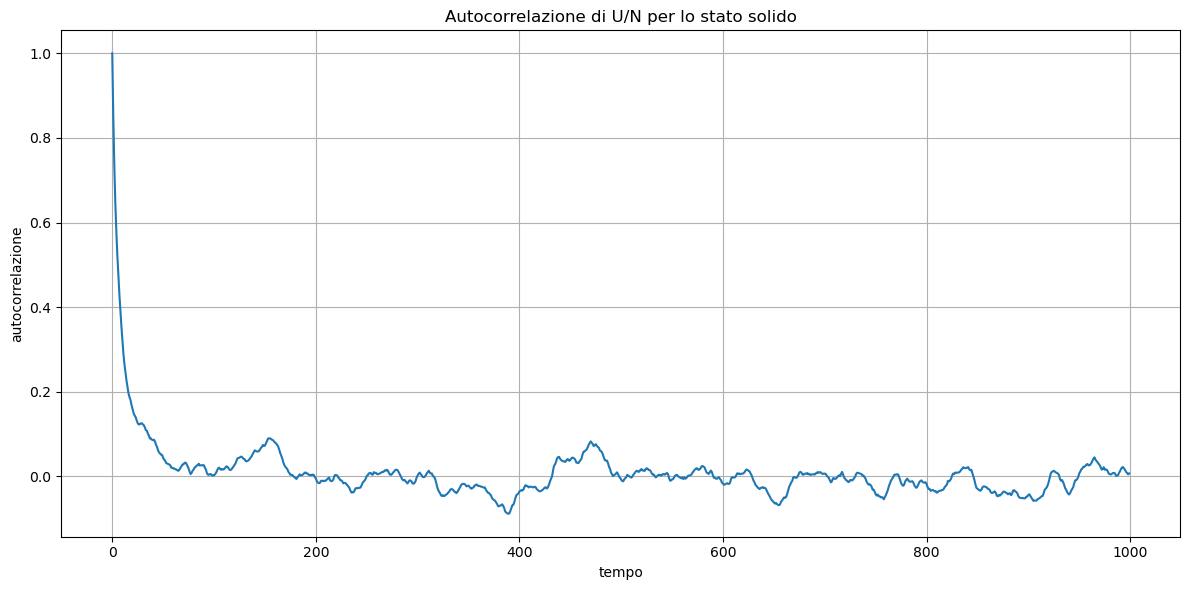

In [4]:
npoints = 1000
x = np.arange(npoints)
autocorr = np.empty(npoints)
TMAX = 10000

fig, ax = plt.subplots(figsize = (12, 6))

# solid
data, tmax = importData("code/solid/MC/data-7.2.out")

autocorr = autocorrelation(data, TMAX, npoints)
clear_output(True)

ax.plot(x, autocorr)
ax.grid(True)
ax.set(title = "Autocorrelazione di U/N per lo stato solido", xlabel = "tempo", ylabel = "autocorrelazione")


fig.tight_layout()
plt.show()

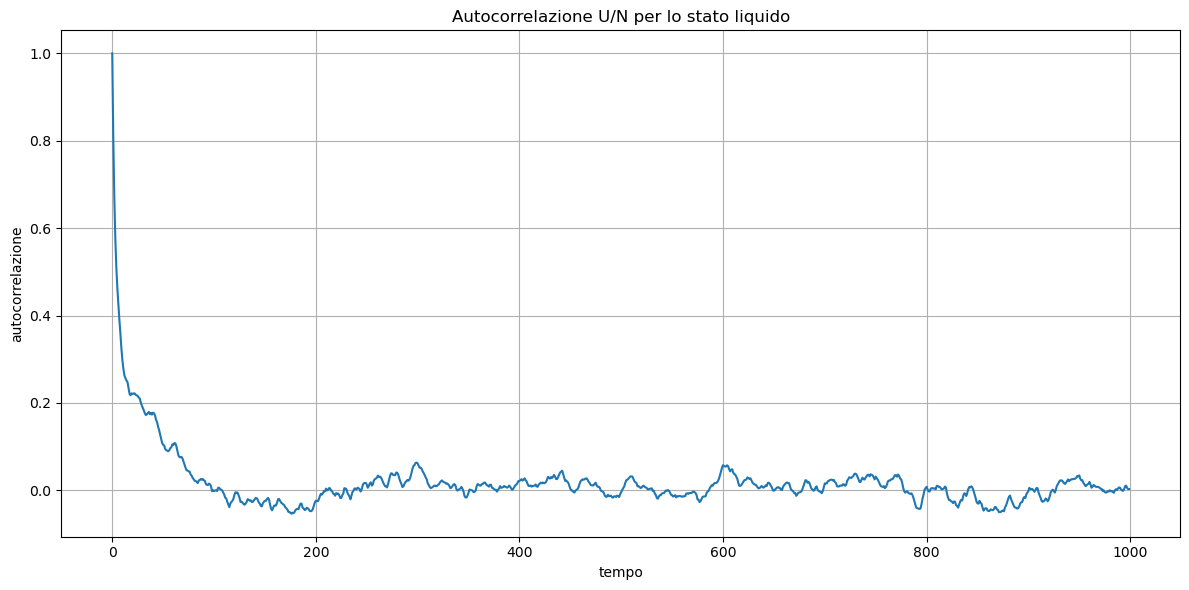

In [5]:
fig, ax = plt.subplots(figsize = (12, 6))

# liquid
data, tmax = importData("code/liquid/MC/data-7.2.out")

autocorr = autocorrelation(data, TMAX, npoints)
clear_output(True)

ax.plot(x, autocorr)
ax.grid(True)
ax.set(title = "Autocorrelazione U/N per lo stato liquido", xlabel = "tempo", ylabel = "autocorrelazione")

fig.tight_layout()
plt.show()

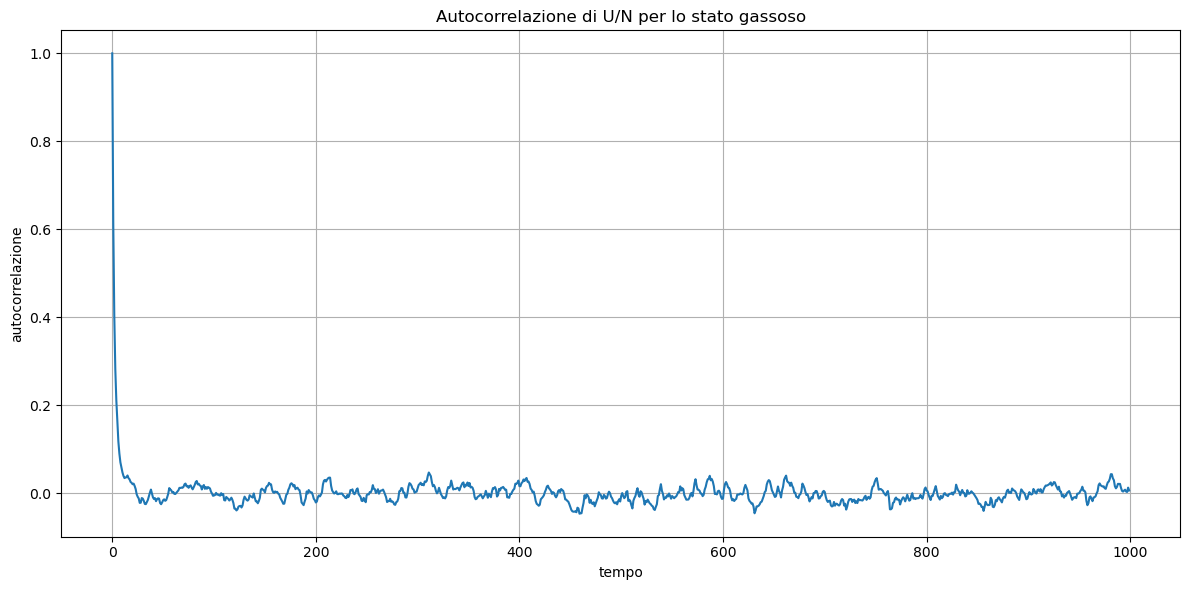

In [6]:
fig, ax = plt.subplots(figsize = (12, 6))

# gas
data, tmax = importData("code/gas/MC/data-7.2.out")

autocorr = autocorrelation(data, TMAX, npoints)
clear_output(True)

ax.plot(x, autocorr)
ax.grid(True)
ax.set(title = "Autocorrelazione di U/N per lo stato gassoso", xlabel = "tempo", ylabel = "autocorrelazione")

fig.tight_layout()
plt.show()

L'autocorrelazione diventa nulla molto prima dei 1000 passi, quindi usando blocchi da più di 1000 passi la media di ogni blocco è scorrelata dalle medie degli altri blocchi.  
Notiamo anche che l'autocorrelazione per lo stato gassoso decade più in fretta. Questo accade perchè le mosse accettate muovono gli atomi nello stato gassoso di distanze molto maggiori rispetto che negli altri due stati. Assumendo un'accettazione del $50\%$, metà delle particelle sarà in una posizione completamente diversa rispetto al passo precedente.

Possiamo usare gli stessi dati per analizzare come cambia l'incertezza calcolata con il metodo della media a blocchi al variare della lunghezza del blocco.  
Abbiamo $M=5\times 10^5$ dati; il numero di blocchi $N$ è dato da $N=M/L$, con $L$ lunghezza del blocco.

In [7]:
def generateBlocks(data, nblocks, blockLength):
    blocks = np.zeros(nblocks)
    for iblock in range(nblocks):

        for i in range(blockLength):
            blocks[iblock] += data[iblock * blockLength + i]
        
        blocks[iblock] /= blockLength

    return blocks



def uncertainty(data):
    sum = sum2 = 0
    for x in data:
        sum += x
        sum2 += x * x

    N = len(data)
    return np.sqrt(((1 / N) * (sum2 - sum * sum / N)) / (N - 1))



def generateErrors(data, lengths):
    errors = np.empty(len(lengths))

    for i in range(len(lengths)):
        nblocks = int(ndata / lengths[i])
        blocks = generateBlocks(data, nblocks, lengths[i])
        errors[i] = uncertainty(blocks)
    
    return errors

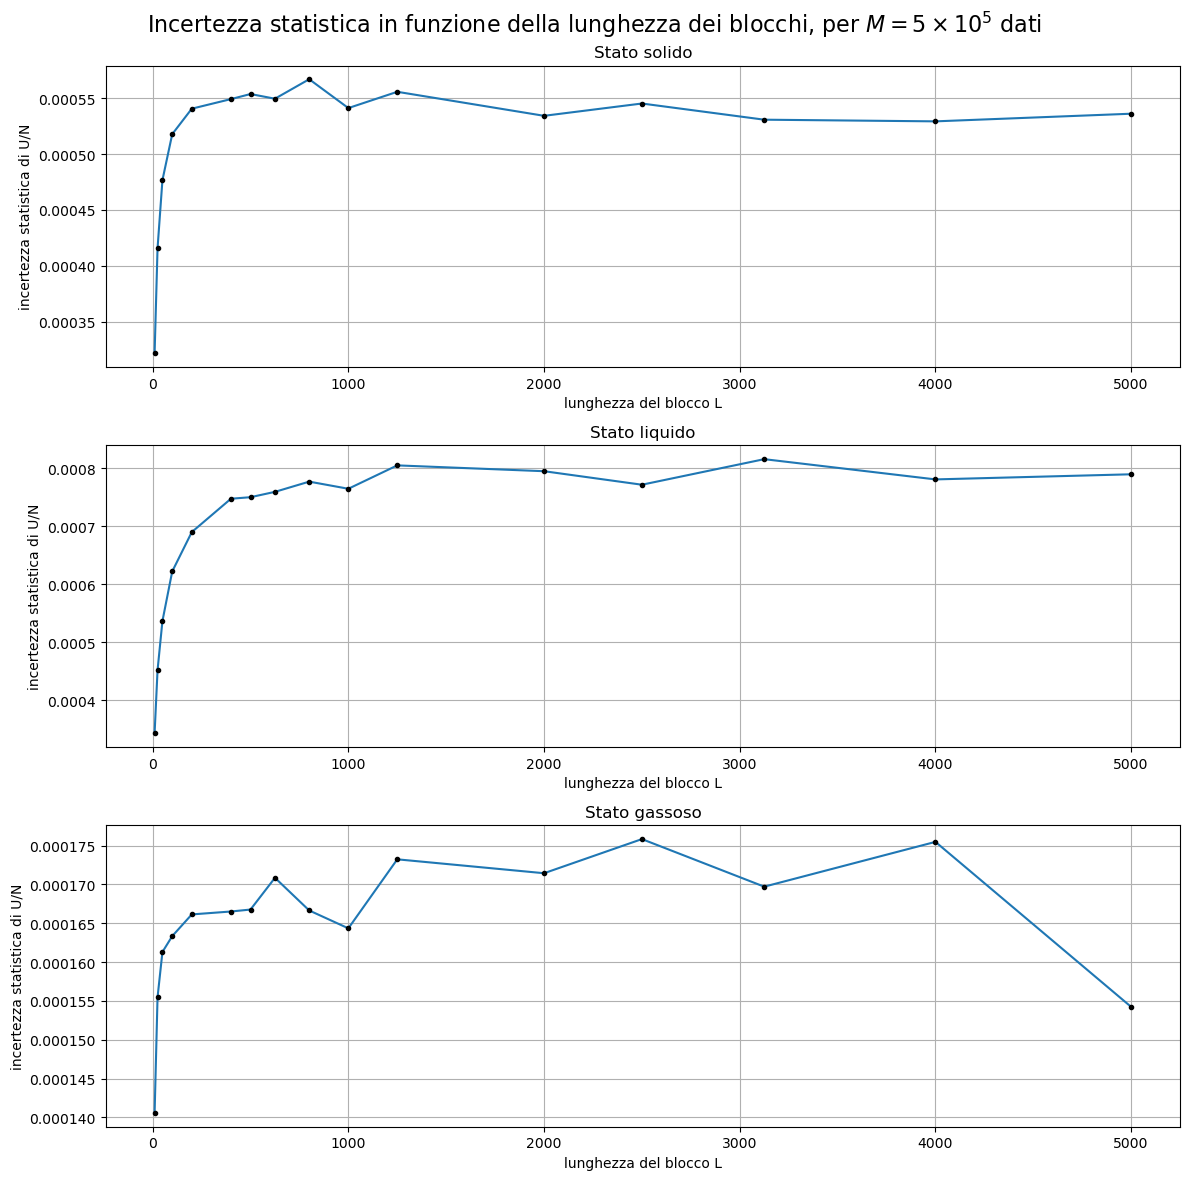

In [8]:
# block lengths, they must be divisors of the number of data (5*10^5)
lengths = [10, 25, 50, 100, 200, 400, 500, 625, 800, 1000, 1250, 2000, 2500, 3125, 4000, 5000]

fig, ax = plt.subplots(3, 1, figsize = (12, 12))

print("start")

# solid
data, ndata = importData("code/solid/MC/data-7.2.out")
errors = generateErrors(data, lengths)

ax[0].plot(lengths, errors, marker = ".", mfc = "black", mec = "black")
ax[0].grid(True)
ax[0].set(title = "Stato solido", xlabel = "lunghezza del blocco L", ylabel = "incertezza statistica di U/N")

print("solid done")


# liquid
data, ndata = importData("code/liquid/MC/data-7.2.out")
errors = generateErrors(data, lengths)

ax[1].plot(lengths, errors, marker = ".", mfc = "black", mec = "black")
ax[1].grid(True)
ax[1].set(title = "Stato liquido", xlabel = "lunghezza del blocco L", ylabel = "incertezza statistica di U/N")

print("liquid done")


# gas
data, ndata = importData("code/gas/MC/data-7.2.out")
errors = generateErrors(data, lengths)

ax[2].plot(lengths, errors, marker = ".", mfc = "black", mec = "black")
ax[2].grid(True)
ax[2].set(title = "Stato gassoso", xlabel = "lunghezza del blocco L", ylabel = "incertezza statistica di U/N")

print("gas done")


clear_output(True)

fig.suptitle(r"Incertezza statistica in funzione della lunghezza dei blocchi, per $M=5\times 10^5$ dati", fontsize = 16)
fig.tight_layout()
plt.show()

L'incertezza diventa costante in tutti i casi dopo circa $L=1000$ passi. Nelle simulazioni successive useremo blocchi da $L=2000$ passi per minimizzare gli effetti dell'autocorrelazione e perché in questa analisi $L=1000$ corrisponde a $N=500$ blocchi, mentre noi ne useremo solo $N=100$.

<h3 style = "color: blue"> Esercizio 7.4 </h3>

Analizziamo quindi i dati di energia potenziale $U/N$ e pressione $P$ ottenuti dalle tre simulazioni Monte Carlo. Riportiamo anche i grafici finali della funzione di distribuzione radiale $g(r)$ nei tre stati, calcolata sia nella simulazione con l'algoritmo di Metropolis sia in quella di dinamica molecolare.

In [15]:
def loadFile(name):
    dataFile = open(name, "r")
    lines = dataFile.readlines()
    fileLength = len(lines)
    mean = np.empty(fileLength)
    uncertainty = np.empty(fileLength)
    for i in range(fileLength):
        values = lines[i].split()
        mean[i], uncertainty[i] = float(values[2]), float(values[3])

    dataFile.close()

    return mean, uncertainty, fileLength



def loadGr(name):
    dataFile = open(name, "r")
    lines = dataFile.readlines()
    fileLength = len(lines)
    r = np.empty(fileLength)
    g = np.empty(fileLength)
    uncertainty = np.empty(fileLength)
    for i in range(fileLength):
        values = lines[i].split()
        r[i], g[i], uncertainty[i] = float(values[0]), float(values[1]), float(values[2])

    dataFile.close()

    return r, g, uncertainty, fileLength



def plotData(state):
    path = "code/" + state + "/MC/"
    
    print("Valori finali in unità ridotte:")
    
    fig, ax = plt.subplots(2, 1, figsize = (12, 10))

    
    mean, uncertainty, fileLength = loadFile(path + "output_epot.dat")
    x = np.arange(fileLength) + 1

    ax[0].errorbar(x, mean, yerr = uncertainty, color = "black", ecolor = "#1f77b4")
    ax[0].set(title = "Energia potenziale U/N", xlabel = "#blocco", ylabel = "U $[\epsilon]$")
    ax[0].grid(True)
    
    print("<U/N> = %.5f +- %.5f" % (mean[-1], uncertainty[-1]))

    
    mean, uncertainty, fileLength = loadFile(path + "output_pres.dat")
    x = np.arange(fileLength) + 1

    ax[1].errorbar(x, mean, yerr = uncertainty, color = "black", ecolor = "#1f77b4")
    ax[1].set(title = "Pressione P", xlabel = "#blocco", ylabel = "P $[\epsilon /\sigma ^3]$")
    ax[1].grid(True)
    
    print("<P> = %.5f +- %.5f" % (mean[-1], uncertainty[-1]))
    

    fig.tight_layout()
    plt.show()
    
    return



def plotGr(state, rho = 0):
    fig, ax = plt.subplots(figsize = (12, 6))
    
    if state == "solid":
        # for an fcc lattice, rho=4/a^3
        a = np.cbrt(4./rho)

        # the nearest 3 neighbours are at a/sqrt(2), a and a*sqrt(2)
        ax.axvline(a / np.sqrt(2), color = "#9c9c9c", label = "Posizioni dei primi vicini nel reticolo fcc")
        ax.axvline(a, color = "#9c9c9c")
        ax.axvline(a * np.sqrt(3./2.), color = "#9c9c9c")
        ax.axvline(a * np.sqrt(2), color = "#9c9c9c")
    
    # potential minimum
    ax.axvline(2 ** (1/6), color = "black", label = "minimo del potenziale")
    
        
    
    path = "code/" + state + "/MD/"
    r, g, uncertainty, nBins = loadGr(path + "output_grfinal.dat")
    
    ax.errorbar(r, g, uncertainty, label = "Dinamica molecolare", color = "#d82786")
    
    
    path = "code/" + state + "/MC/"
    r, g, uncertainty, nBins = loadGr(path + "output_grfinal.dat")
    
    ax.errorbar(r, g, uncertainty, label = "Metropolis", color = "#1f77b4")
    
    
    ax.set(title = "Funzione di distribuzione radiale g(r)", xlabel = "$r$ $[\sigma]$", ylabel = "$g(r)$")
    ax.grid(True)
    plt.legend()
    fig.tight_layout()
    plt.show()
    
    return

<h4> Stato solido </h4>

Valori finali in unità ridotte:
<U/N> = -7.54562 +- 0.00086
<P> = 7.59858 +- 0.00469


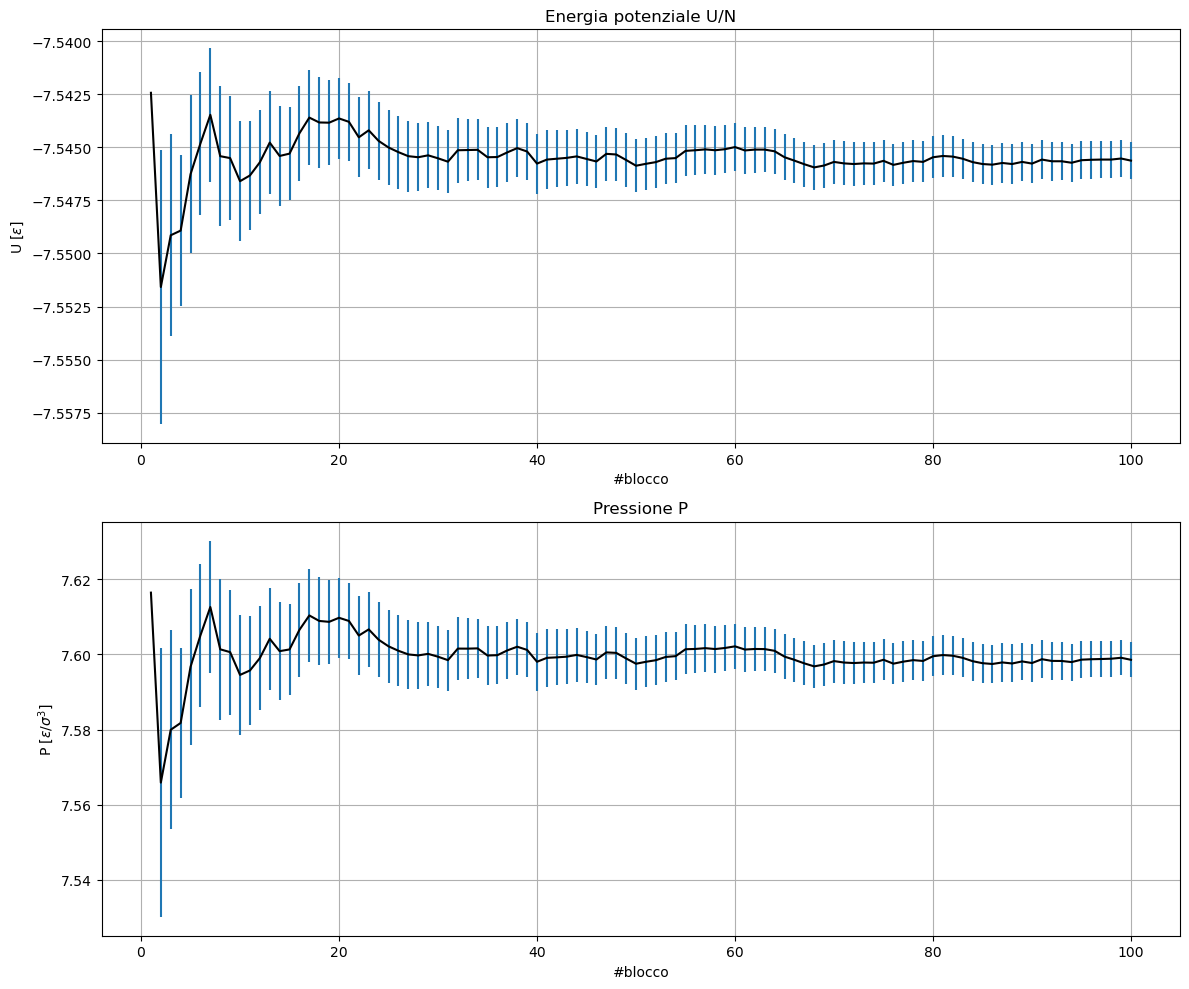

In [16]:
plotData("solid")

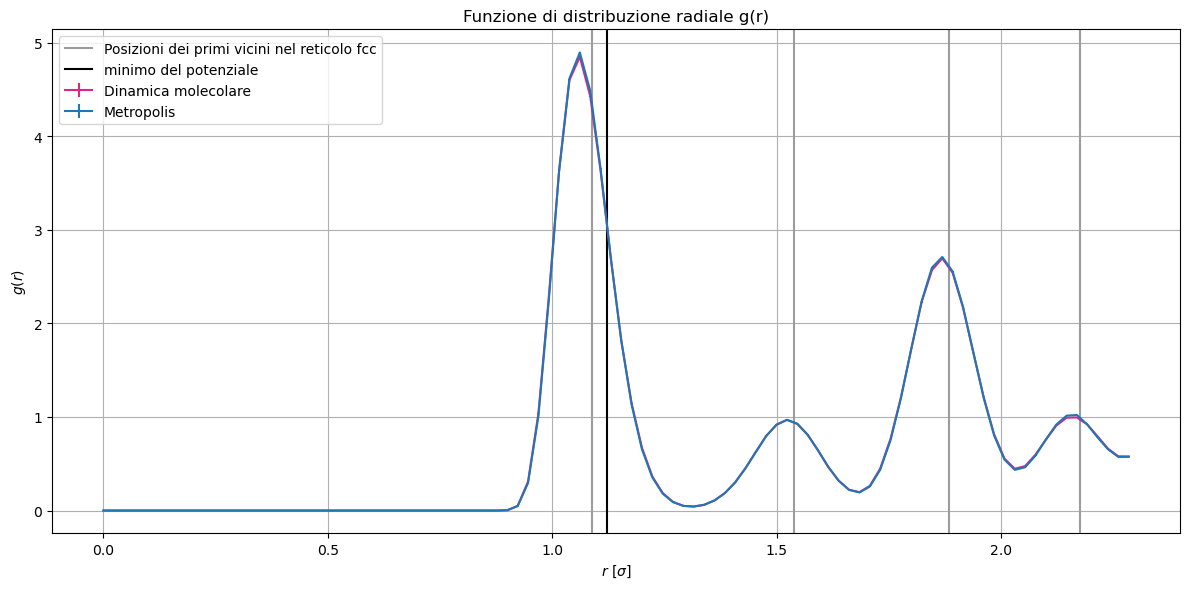

In [17]:
plotGr("solid", 1.1)

<h4> Stato liquido </h4>

Valori finali in unità ridotte:
<U/N> = -5.46343 +- 0.00118
<P> = 1.39849 +- 0.00649


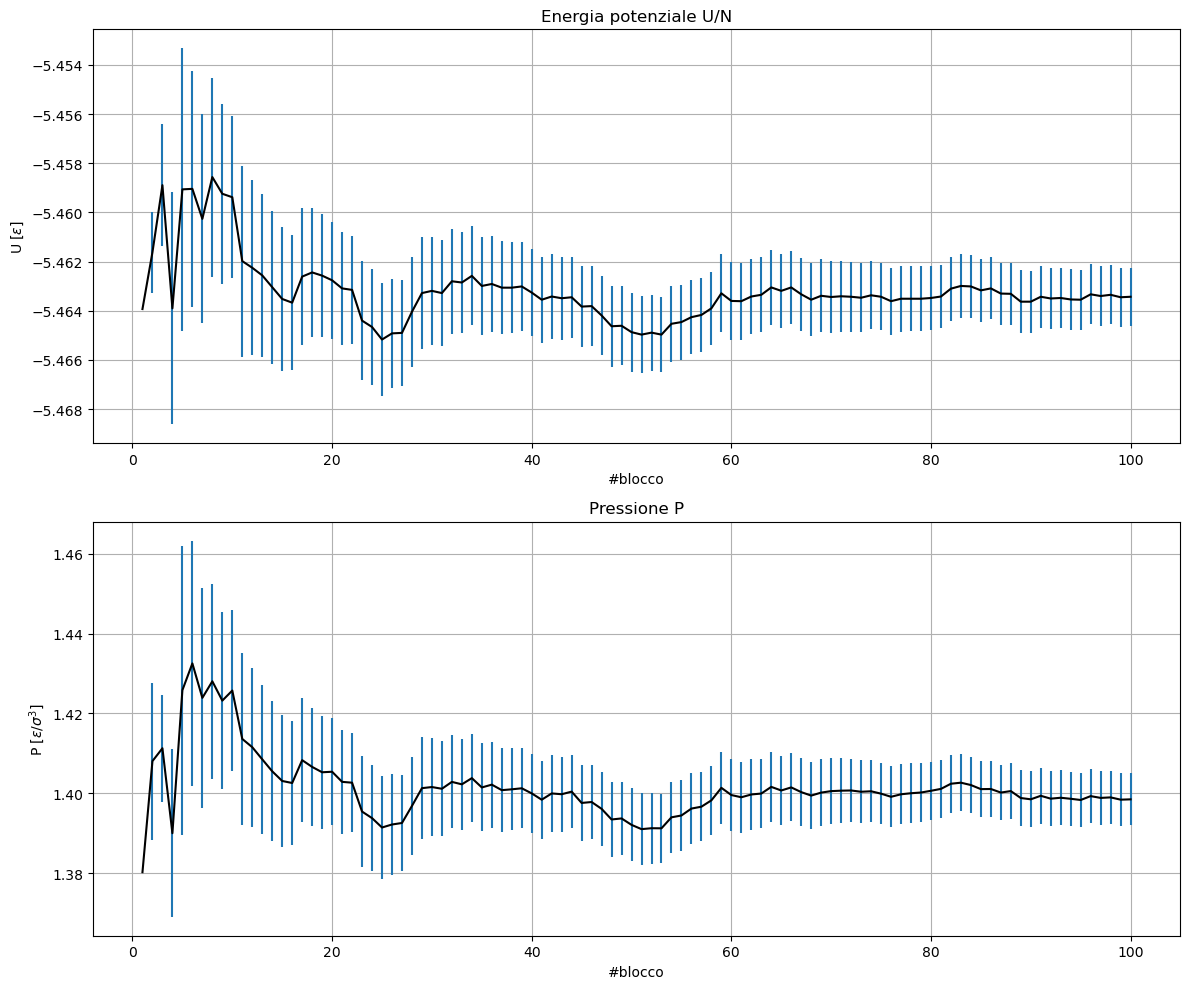

In [18]:
plotData("liquid")

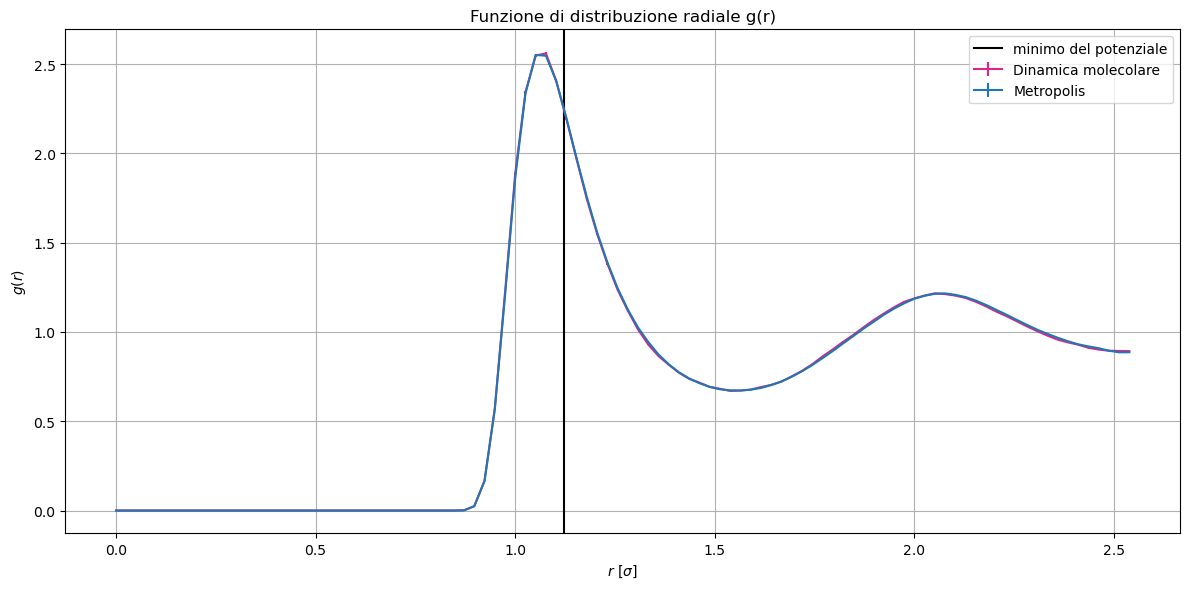

In [19]:
plotGr("liquid")

<h4> Stato gassoso </h4>

Valori finali in unità ridotte:
<U/N> = -0.41403 +- 0.00026
<P> = 0.04906 +- 0.00002


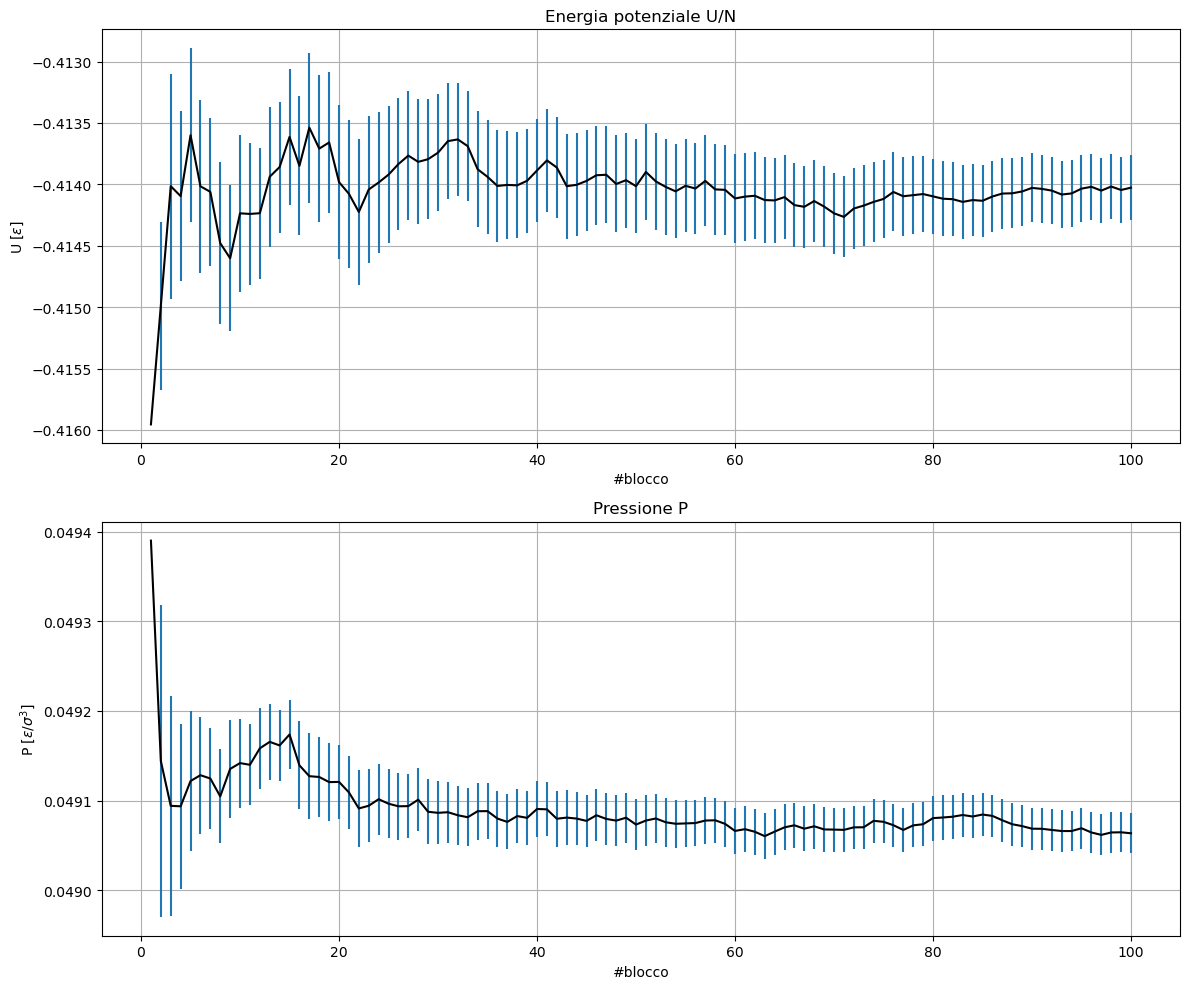

In [20]:
plotData("gas")

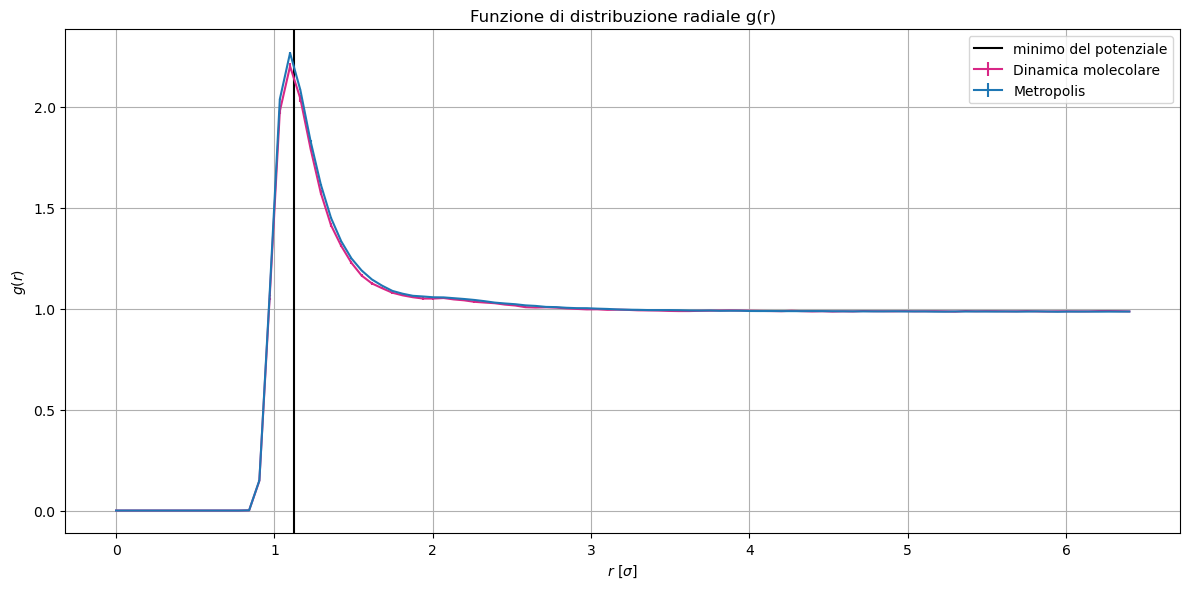

In [21]:
plotGr("gas")

<h4> Conclusioni </h4>

In tutti e tre gli stati, i valori di $U/N$ e $P$ convergono velocemente al valore finale. La funzione $g(r)$ mostra come il solido sia molto vicino alla struttura cristallina perfetta cubica a facce centrate (fcc) dell'argon. Per gli altri due stati c'è ancora un picco in prossimità di $r=2^{1/6}\sigma$, cioè nel minimo del potenziale. Nel liquido c'è un secondo picco, segno che la struttura non è completamente caotica; nel gas invece, dopo il primo picco, $g(r)=1$, segno che le altre particelle possono trovarsi in qualunque punto.